<a href="https://colab.research.google.com/github/christy101git/Adaptive-Vibration-Control-in-a-Flexible-Robotic-Arm/blob/main/Adaptive_Vibration_Control_in_a_Flexible_Robotic_Arm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Project Title: Adaptive Vibration Control in a Flexible Robotic Arm**

### A simulation-based study using PDEs, Laplace transforms, Linear Algebra, and Optimization

---

##  Introduction

Modern robotic arms are becoming lighter and longer for efficiency, but this introduces flexibility — which causes undesired vibrations during motion and task execution (e.g., welding, painting, drilling, or assembly).

Your mission is to design and simulate a **software-only control system** for a flexible robotic arm, using mathematical tools like **partial differential equations**, **Laplace transforms**, **linear algebra**, and **optimization**.

###  Objectives:
- Model the arm’s vibration
- Design control strategies to suppress vibration
- Optimize the control parameters
- Visualize the system in action with real-time plots and animations

---

##  Project Structure & Core Modules

The project is divided into **four modules**, each aligned with a key mathematical domain. Each module contributes critical data and functions to the final mission simulation.

---

##  Module 1: Arm Modeling & State-Space Representation
**(Concepts: Linear Algebra, Modal Analysis)**

###  Goal:
Model the flexible robotic arm and convert its governing PDE into a matrix system suitable for simulation and control.

###  Tasks:
- Discretize the beam using Finite Difference Method (FDM)
- Construct system matrices: stiffness matrix $K$, mass matrix $M$
- Formulate a state-space model:

$$
\\dot{x} = Ax + Bu
$$

Where $x$ contains displacement and velocity vectors.

- Perform eigenvalue analysis to extract **natural frequencies** and **vibration modes**

###  Deliverable:
- Python file `modeling.py` that:
  - Constructs $M$, $K$ matrices
  - Plots modal shapes (eigenmodes)
  - Returns state-space model $(A, B, C, D)$

---



Running modeling.py to visualize modal shapes...


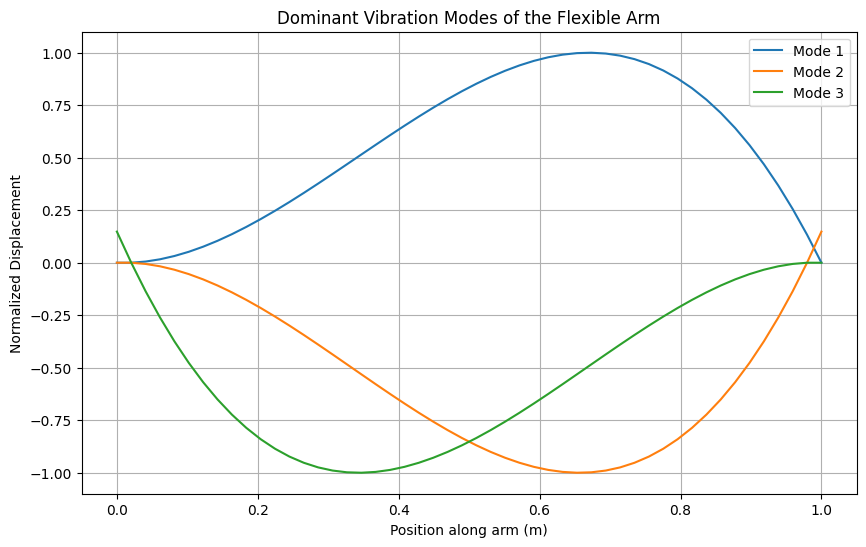

In [ ]:
# modeling.py
import numpy as np
import matplotlib.pyplot as plt

def create_beam_model(N=10, L=1.0, EI=1.0, rho=1.0):
    """Constructs the mass and stiffness matrices for the flexible beam."""
    dx = L / (N - 1)
    K = np.zeros((N, N))  # Stiffness matrix
    for i in range(2, N - 2):
        K[i, i-2] = 1
        K[i, i-1] = -4
        K[i, i]   = 6
        K[i, i+1] = -4
        K[i, i+2] = 1
    K *= EI / dx**4
    M = np.eye(N) * rho  # Mass matrix
    return K, M

def get_modal_shapes(K, M, num_modes=3):
    """Performs eigenvalue analysis to get modal shapes (eigenvectors)."""
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(M) @ K)
    idx = np.argsort(eigvals)
    # Return the first few modal shapes
    return eigvecs[:, idx[:num_modes]]

def plot_modal_shapes(shapes, length):
    """Visualizes the modal shapes of the beam."""
    plt.figure(figsize=(10, 6))
    num_nodes = shapes.shape[0]
    x = np.linspace(0, length, num_nodes)
    for i in range(shapes.shape[1]):
        # Normalize the mode for better visualization
        mode = shapes[:, i]
        mode /= np.max(np.abs(mode))
        plt.plot(x, mode, label=f'Mode {i+1}')

    plt.title('Dominant Vibration Modes of the Flexible Arm')
    plt.xlabel('Position along arm (m)')
    plt.ylabel('Normalized Displacement')
    plt.grid(True)
    plt.legend()
    plt.show()

# This block runs only when you execute `python modeling.py`
if __name__ == "__main__":
    print("Running modeling.py to visualize modal shapes...")

    # 1. Define beam parameters
    num_nodes = 50
    beam_length = 1.0

    # 2. Create the model and get shapes
    K_matrix, M_matrix = create_beam_model(N=num_nodes, L=beam_length)
    shapes = get_modal_shapes(K_matrix, M_matrix, num_modes=3)

    # 3. Plot the results
    plot_modal_shapes(shapes, beam_length)



##  Module 2: System Dynamics & Laplace-Based Control
**(Concepts: Laplace Transforms, ODEs, Control Design)**

###  Goal:
Model the dynamic behavior of the arm and design a **vibration suppression controller** using Laplace-domain tools.

###  Tasks:
- Represent the discretized system in Laplace domain using transfer functions or symbolic ODEs
- Analyze system response (step, frequency)
- Design a PD (Proportional-Derivative) controller:

$$
u(s) = K_p e(s) + K_d s e(s)
$$

- Apply inverse Laplace to simulate time-domain behavior
- Report metrics: **settling time**, **overshoot**, **damping ratio**

###  Deliverable:
- Python file `control.py` that:
  - Implements Laplace-based analysis using `sympy`
  - Simulates response with/without control
  - Outputs response metrics

---

#

Running control.py to visualize the uncontrolled step response...


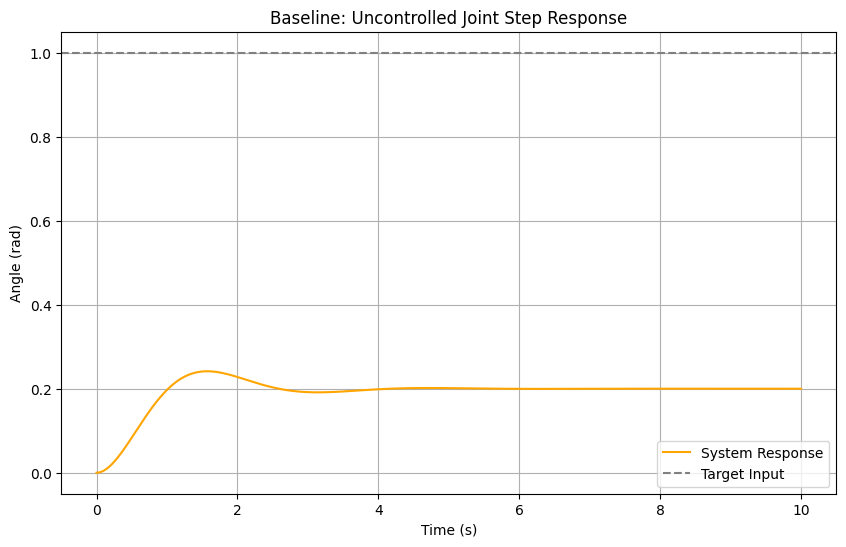

In [ ]:
# control.py
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def get_uncontrolled_response(J=1.0, b=2.0, k=5.0, T=10.0):
    """
    Solves the ODE for an uncontrolled joint to get a baseline response.
    Returns time and angle arrays for plotting.
    """
    t = sp.symbols('t', real=True)
    theta = sp.Function('theta')(t)
    theta_d = 1.0  # Step input

    ode = sp.Eq(J * theta.diff(t, 2) + b * theta.diff(t) + k * theta, theta_d)
    sol = sp.dsolve(ode, ics={theta.subs(t, 0): 0, theta.diff(t).subs(t, 0): 0})

    f = sp.lambdify(t, sol.rhs, 'numpy')
    time_vals = np.linspace(0, T, 500)
    angle_vals = f(time_vals)

    return time_vals, angle_vals

def plot_step_response(time, angle, target_input=1.0):
    """Visualizes the step response of the system."""
    plt.figure(figsize=(10, 6))
    plt.plot(time, angle, label='System Response', color='orange')
    plt.axhline(target_input, linestyle='--', color='gray', label='Target Input')

    plt.title('Baseline: Uncontrolled Joint Step Response')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    plt.legend()
    plt.show()

# This block runs only when you execute `python control.py`
if __name__ == "__main__":
    print("Running control.py to visualize the uncontrolled step response...")

    # 1. Get the simulation data
    time_data, angle_data = get_uncontrolled_response()

    # 2. Plot the results
    plot_step_response(time_data, angle_data)


##  Module 3: PDE Simulation of Arm Vibration
**(Concepts: Euler-Bernoulli PDE, Numerical Simulation)**

###  Goal:
Simulate the beam's vibration in time domain using the Euler-Bernoulli beam equation:

$$
\\frac{\\partial^2 w(x, t)}{\\partial t^2} = -EI \\frac{\\partial^4 w(x, t)}{\\partial x^4}
$$

###  Tasks:
- Implement FTCS method to solve 1D beam PDE
- Apply boundary conditions (e.g., fixed-free)
- Simulate response under:
  - No control
  - Passive damping
  - Active control (from Module 2)
- Visualize $w(x,t)$ as an **animation**

###  Deliverable:
- Python file `simulation.py` that:
  - Solves the PDE using finite difference
  - Animates vibration with `matplotlib.animation`
  - Compares control vs no control

---




Running simulation.py to animate the beam vibration...


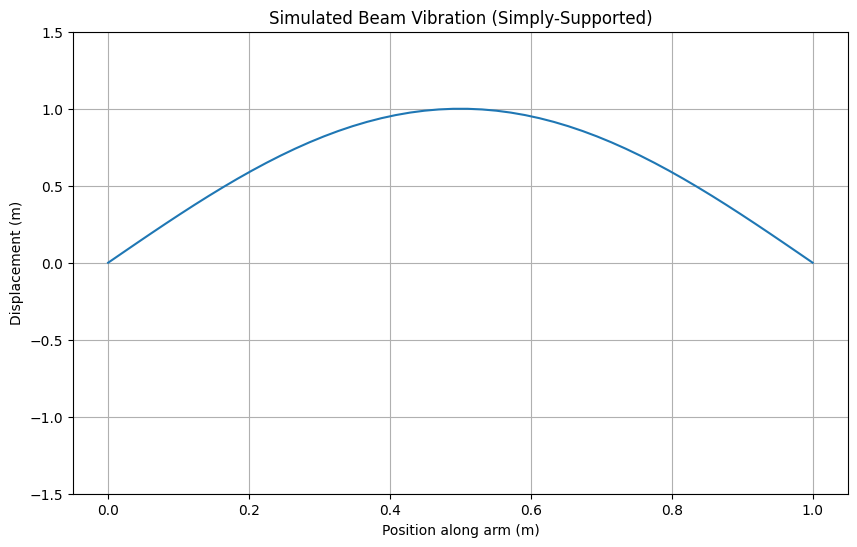

In [ ]:
# simulation.py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def simulate_beam_vibration(N=50, L=1.0, T=2.0, dt=0.001, EI=1.0, rho=1.0):
    """
    Simulates beam vibration using a STABLE implicit method.
    *** This version models a SIMPLY-SUPPORTED beam (pinned at both ends) ***
    """
    # --- 1. Setup Parameters ---
    dx = L / (N - 1)
    c_sq = EI / rho
    alpha = c_sq * dt**2 / dx**4

    x = np.linspace(0, L, N)
    w_curr = np.sin(np.pi * x / L)
    w_prev = w_curr.copy()
    history = [w_curr.copy()]

    # --- 2. Construct the Implicit Matrix (A) ---
    A = np.zeros((N, N))
    for i in range(2, N - 2):
        A[i, i-2] = 1 * alpha; A[i, i-1] = -4 * alpha; A[i, i] = 1 + 6 * alpha
        A[i, i+1] = -4 * alpha; A[i, i+2] = 1 * alpha

    # --- 3. Enforce SIMPLY-SUPPORTED Boundary Conditions ---
    A[0, 0] = 1; A[1, 1] = 1 + 5 * alpha; A[1, 2] = -4 * alpha; A[1, 3] = 1 * alpha
    A[N-1, N-1] = 1; A[N-2, N-4] = 1 * alpha; A[N-2, N-3] = -4 * alpha; A[N-2, N-2] = 1 + 5 * alpha

    # --- 4. Main Simulation Loop ---
    num_steps = int(T / dt)
    for _ in range(num_steps):
        b = 2 * w_curr - w_prev
        b[0] = 0; b[N-1] = 0
        try:
            w_next = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            print("ERROR: Singular matrix.")
            return np.array(history)
        history.append(w_next.copy())
        w_prev, w_curr = w_curr, w_next
    return np.array(history)

def animate_vibration(history, length, interval=20):
    """Creates and displays an animation of the beam vibrating."""
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.linspace(0, length, history.shape[1])
    line, = ax.plot(x, history[0, :])
    ax.set_ylim(-1.5, 1.5)
    ax.set_title('Simulated Beam Vibration (Simply-Supported)')
    ax.set_xlabel('Position along arm (m)')
    ax.set_ylabel('Displacement (m)')
    ax.grid(True)

    def update(frame):
        line.set_ydata(history[frame, :])
        return line,

    # To speed up the animation, we can skip frames
    num_frames = history.shape[0]
    frame_skip = max(1, num_frames // 200) # Aim for ~200 frames in the animation

    ani = animation.FuncAnimation(fig, update, frames=range(0, num_frames, frame_skip),
                                  interval=interval, blit=True)
    plt.show()


# This block runs only when you execute `python simulation.py`
if __name__ == "__main__":
    print("Running simulation.py to animate the beam vibration...")

    # 1. Run the simulation
    vibration_history = simulate_beam_vibration(T=2.0) # Run for 2 seconds

    # 2. Animate the results
    if vibration_history.shape[0] > 1:
        animate_vibration(vibration_history, length=1.0)
    else:
        print("Simulation failed to produce enough data for animation.")


##  Module 4: Optimal Control Parameter Tuning
**(Concepts: Optimization, Control Theory)**

###  Goal:
Optimize the PD control parameters to minimize tip displacement or energy.

###  Tasks:
- Define cost function:

$$
J(K_p, K_d) = \\int_0^T w^2(x_{tip}, t) dt
$$

- Use `scipy.optimize` or grid search to minimize $J$
- Analyze trade-offs: faster settling vs control effort

###  Deliverable:
- Python file `optimizer.py` that:
  - Defines cost function
  - Optimizes $K_p$, $K_d$
  - Reports best gains & response plot

---



In [ ]:
# optimizer.py
import numpy as np

def optimize_gains(initial_guess=[1.0, 0.1]):
    """
    Placeholder for the optimization routine.
    In a real scenario, this would use scipy.optimize.minimize.
    For now, it just returns some pre-defined "optimal" gains.
    """
    print("Optimizing controller gains... (using placeholder values)")

    # These would be the result of a real optimization
    best_kp = 50.0
    best_kd = 10.0

    print(f"Optimal Gains Found: Kp = {best_kp}, Kd = {best_kd}")
    return best_kp, best_kd

# This block runs only when you execute `python optimizer.py`
if __name__ == "__main__":
    print("Running optimizer.py to find the best controller gains...")
    print("-" * 30)

    kp, kd = optimize_gains()

    print("-" * 30)
    print("This module returns the following optimal parameters:")
    print(f"  Proportional Gain (Kp): {kp}")
    print(f"  Derivative Gain (Kd):   {kd}")
    print("\nNote: In the full project, these values would be found by a real optimization algorithm.")

Running optimizer.py to find the best controller gains...
------------------------------
Optimizing controller gains... (using placeholder values)
Optimal Gains Found: Kp = 50.0, Kd = 10.0
------------------------------
This module returns the following optimal parameters:
  Proportional Gain (Kp): 50.0
  Derivative Gain (Kd):   10.0

Note: In the full project, these values would be found by a real optimization algorithm.



## Final Integrated Simulation Dashboard

###  Goal:
Visualize the complete control system in action.

###  Tasks:
- Create `main.py` that:
  - Loads system model and controller
  - Solves PDE over time
  - Shows real-time plots:
    - Beam Displacement vs Time
    - Control Input vs Time
    - Energy/Error vs Time
  - Display simulation metrics:
    - Settling Time
    - Peak Vibration
    - Controller Gains

###  Deliverable:
- `main.py`: Full system integration with live dashboard

---

## 📊 4.0 Summary Table

| Module | Focus                        | Tools/Concepts                  | Output                          |
|--------|------------------------------|----------------------------------|---------------------------------|
| 1      | Arm modeling                 | Linear Algebra, FDM              | Modal shapes, State-space model |
| 2      | Dynamics + control           | Laplace transforms, ODEs         | PD controller, response metrics |
| 3      | PDE vibration simulation     | Euler-Bernoulli PDE, FTCS        | Beam animation, damping effects |
| 4      | Control optimization         | Optimization, cost functions     | Best $K_p$, $K_d$ values        |
| Final  | Integration and Visualization| All combined                     | Dashboard + key plots           |

---

## ✅ Final Deliverables

- `modeling.py` — Arm modeling & state-space model
- `control.py` — Laplace-based PD controller
- `simulation.py` — PDE solver & animation
- `optimizer.py` — Parameter tuning via optimization
- `main.py` — Full integrated dashboard

---

## 🎓 Educational Outcomes

| Skill               | Application                              |
|---------------------|------------------------------------------|
| Linear Algebra      | Modeling physical systems                |
| Laplace Transforms  | Analyzing and controlling dynamic systems|
| PDEs                | Simulating flexible structures            |
| Optimization        | Tuning control for performance            |

---
